In [2]:
import pandas as pd, numpy as np,matplotlib.pyplot as plt, seaborn as snb , os, cv2 as cv,random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Input, MaxPool2D,BatchNormalization, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg16 import VGG16

2025-07-22 14:35:36.555997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753194936.774155      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753194936.839759      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
base_path = r"/kaggle/input/tumor-data/Tumor_data/train"
def load_dataset(base_path):
    disease_path =[]
    for disease in os.listdir(base_path):
        if disease != "_classes.csv":
            disease_path.append(os.path.join(base_path,disease))
    disease = {'glioma':None,'meningioma':None,'pituitary':None,'no_tumor':None}
    for i,keys in enumerate(disease.keys()):
        List = []
        for image in os.listdir(disease_path[i]):
            List.append(os.path.join(disease_path[i],image))
        disease[keys] = List
    return disease
disease = load_dataset(base_path)
disease

{'glioma': ['/kaggle/input/tumor-data/Tumor_data/train/pituitary/Tr-pi_0069_jpg.rf.04040d1ecfcbd58d5c0bce59db628e65.jpg',
  '/kaggle/input/tumor-data/Tumor_data/train/pituitary/Tr-pi_0401_jpg.rf.aded42ba8fe55111f90d0ae6cf292d96.jpg',
  '/kaggle/input/tumor-data/Tumor_data/train/pituitary/Tr-pi_0348_jpg.rf.ef9a02f4d66fc4fe8ff1d9a36c4ba6cf.jpg',
  '/kaggle/input/tumor-data/Tumor_data/train/pituitary/Tr-pi_0305_jpg.rf.49e5ff630e26ad5c1973c7e01abe7345.jpg',
  '/kaggle/input/tumor-data/Tumor_data/train/pituitary/Tr-pi_0642_jpg.rf.d6a21faa591e115e3f385103d26526c0.jpg',
  '/kaggle/input/tumor-data/Tumor_data/train/pituitary/Tr-pi_0255_jpg.rf.3a67141afcd13255c36a50ae611b1469.jpg',
  '/kaggle/input/tumor-data/Tumor_data/train/pituitary/Tr-pi_0350_jpg.rf.1ed058df753d13bf5e4c4398478fca51.jpg',
  '/kaggle/input/tumor-data/Tumor_data/train/pituitary/Tr-pi_0535_jpg.rf.d5e992061fd27f863e75741778faad2f.jpg',
  '/kaggle/input/tumor-data/Tumor_data/train/pituitary/Tr-pi_0558_jpg.rf.1a6a23d7e5c955895467b

(640, 640, 3)


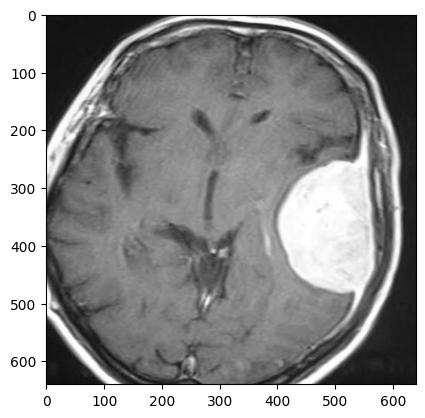

In [4]:
disease_name = ['glioma','meningioma','pituitary','no_tumor']
def show_image(disease_name):
    image = cv.imread(disease[disease_name][random.randint(0,len(disease[disease_name]))])
    plt.imshow(image)
    image = np.array(image)
    print(image.shape)
show_image('pituitary')


In [5]:
df = pd.DataFrame({'Image_path':disease['glioma'],'Label':['glioma' for i in range(len(disease['glioma']))]})
df1 = pd.DataFrame({'Image_path':disease['meningioma'],'Label':['meningioma' for i in range(len(disease['meningioma']))]})
df2 = pd.DataFrame({'Image_path':disease['pituitary'],'Label':['pituitary' for i in range(len(disease['pituitary']))]})
df3 = pd.DataFrame({'Image_path':disease['no_tumor'],'Label':['no_tumor' for i in range(len(disease['no_tumor']))]})
df = pd.concat([df,pd.concat([df1,pd.concat([df2,df3])])])
df

,Image_path,Label
0,/kaggle/input/tumor-data/Tumor_data/train/pitu...,glioma
1,/kaggle/input/tumor-data/Tumor_data/train/pitu...,glioma
2,/kaggle/input/tumor-data/Tumor_data/train/pitu...,glioma
3,/kaggle/input/tumor-data/Tumor_data/train/pitu...,glioma
4,/kaggle/input/tumor-data/Tumor_data/train/pitu...,glioma
...,...,...
559,/kaggle/input/tumor-data/Tumor_data/train/glio...,no_tumor
560,/kaggle/input/tumor-data/Tumor_data/train/glio...,no_tumor
561,/kaggle/input/tumor-data/Tumor_data/train/glio...,no_tumor
562,/kaggle/input/tumor-data/Tumor_data/train/glio...,no_tumor


In [6]:
def load_and_resize_image(path, size=(224, 224)):
    img = cv.imread(path)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    img = cv.resize(img, size)
    img = img.astype(np.float32) / 255.0  # normalize
    return img

# Replace each image path with its corresponding matrix
df['Image_matrix'] = df['Image_path'].apply(lambda path: load_and_resize_image(path))
df = df.drop(columns=['Image_path'])

df

,Label,Image_matrix
0,glioma,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,glioma,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,glioma,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,glioma,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,glioma,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
...,...,...
559,no_tumor,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
560,no_tumor,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
561,no_tumor,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
562,no_tumor,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


In [7]:
df['Image_matrix'].shape

(1695,)

In [8]:
# label_map = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'no_tumor': 3}
# df['label'] = df['Label'].map(label_map)
# df = df.drop(columns= ['Label'])
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
df

,Label,Image_matrix
0,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
...,...,...
559,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
560,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
561,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
562,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


In [9]:
x_train,y_train = np.stack(df['Image_matrix'].values),to_categorical(df['Label'],num_classes=4)
x_train

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314]],

        [[0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.01568628, 0.01568628, 0.01568628],
         [0.01568628, 0.01568628, 0.01568628],
         [0.01568628, 0.01568628, 0.01568628]],

        ...,

        [[0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412]

In [10]:
y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [11]:
type(y_train)

numpy.ndarray

In [12]:

disease_name = ['glioma','meningioma','pituitary','no_tumor']

base_path = r"/kaggle/input/tumor-data/Tumor_data/test"
disease = load_dataset(base_path)


df = pd.DataFrame({'Image_path':disease['glioma'],'Label':['glioma' for i in range(len(disease['glioma']))]})
df1 = pd.DataFrame({'Image_path':disease['meningioma'],'Label':['meningioma' for i in range(len(disease['meningioma']))]})
df2 = pd.DataFrame({'Image_path':disease['pituitary'],'Label':['pituitary' for i in range(len(disease['pituitary']))]})
df3 = pd.DataFrame({'Image_path':disease['no_tumor'],'Label':['no_tumor' for i in range(len(disease['no_tumor']))]})
df = pd.concat([df,pd.concat([df1,pd.concat([df2,df3])])])
df
def load_and_resize_image(path, size=(224, 224)):
    img = cv.imread(path)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    img = cv.resize(img, size)
    img = img.astype(np.float32) / 255.0  # normalize
    return img

# Replace each image path with its corresponding matrix
df['Image_matrix'] = df['Image_path'].apply(lambda path: load_and_resize_image(path))
df = df.drop(columns=['Image_path'])

df
# label_map = {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'no_tumor': 3}
# df['label'] = df['Label'].map(label_map)
# df = df.drop(columns= ['Label'])
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
df


,Label,Image_matrix
0,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
...,...,...
75,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
76,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
77,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
78,2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


In [13]:
df['Image_matrix'].head(10)

0    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
1    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
2    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
3    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
4    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
5    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
6    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
7    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
8    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
9    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
Name: Image_matrix, dtype: object

In [14]:
x_test,y_test = np.stack(df['Image_matrix'].values),to_categorical(df['Label'],num_classes=4)


In [15]:
model = Sequential([
    Input(shape=(224,224,3)),

    Conv2D(32,(3,3),activation='relu'),
    MaxPool2D((2,2)),

    Conv2D(64,(3,3),activation='relu'), 
    MaxPool2D((2,2)), 


    Flatten(), 
    Dense(128,activation='relu'), 
    Dense(4,activation='softmax')
]
)

I0000 00:00:1753195013.487282      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753195013.487994      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [16]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
model.fit(
    x_train,y_train,
    batch_size=64,
    epochs=5,
    validation_data=(x_test,y_test)
)


Epoch 1/5


I0000 00:00:1753195019.241722     103 service.cc:148] XLA service 0x786d20006350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753195019.242569     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753195019.242594     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753195019.489261     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/27 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.2383 - loss: 2.1778

I0000 00:00:1753195025.237797     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 314ms/step - accuracy: 0.4743 - loss: 2.3501 - val_accuracy: 0.7520 - val_loss: 0.5923
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8472 - loss: 0.4109 - val_accuracy: 0.8577 - val_loss: 0.4134
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9589 - loss: 0.1525 - val_accuracy: 0.8943 - val_loss: 0.3369
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9832 - loss: 0.0648 - val_accuracy: 0.8943 - val_loss: 0.4024
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9984 - loss: 0.0141 - val_accuracy: 0.9024 - val_loss: 0.4173


In [18]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,723,726 (273.60 MB)

 Trainable params: 23,907,908 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,815,818 (182.40 MB)

In [19]:
model_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3),
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
model_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
dense_model = Sequential()

dense_model.add(model_base)
dense_model.add(Flatten())
dense_model.add(Dense(256,activation='relu'))
dense_model.add(Dense(4,activation = 'softmax'))

In [23]:
model_base.trainable = False

In [24]:
dense_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
dense_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'] )

In [26]:
history = dense_model.fit(x_train,y_train,
                          epochs=5,
                          batch_size=64,
                         validation_data=(x_test,y_test))

Epoch 1/5


2025-07-22 14:38:14.565980: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[64,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-07-22 14:38:14.573661: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.007816106s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[64,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5215 - loss: 3.5403 - val_accuracy: 0.8415 - val_loss: 0.4372
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.8772 - loss: 0.3194 - val_accuracy: 0.8496 - val_loss: 0.3453
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 346ms/step - accuracy: 0.9412 - loss: 0.1934 - val_accuracy: 0.8943 - val_loss: 0.2765
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 353ms/step - accuracy: 0.9674 - loss: 0.1291 - val_accuracy: 0.9065 - val_loss: 0.2467
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 362ms/step - accuracy: 0.9768 - loss: 0.1045 - val_accuracy: 0.9106 - val_loss: 0.2481


In [28]:
loss,acc = model.evaluate(x_test,y_test)
loss1,acc1 = dense_model.evaluate(x_test,y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9233 - loss: 0.3476
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9209 - loss: 0.2299 


In [29]:
y_test = df['Label']
y_test

0     0
1     0
2     0
3     0
4     0
     ..
75    2
76    2
77    2
78    2
79    2
Name: Label, Length: 246, dtype: int64

In [ ]:
print(f"Test accuracy: {acc:.2f}")


In [ ]:
y_pred = model.predict(x_test)

results = pd.DataFrame({'prediction':[np.argmax(i)for i in y_pred],'acctual':y_test})


In [ ]:
results

In [ ]:
for i in y_pred:
    print(np.argmax(i))

In [ ]:
y_pred